In [10]:
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from idaes.models.properties.modular_properties.base.generic_property import (
    GenericParameterBlock)

from idaes.models.properties.modular_properties.base.generic_reaction import GenericReactionParameterBlock

import idaes.core.util.scaling as iscale
from ammonia_PR import (
    get_prop,
    EosType,
    get_rxn
)
from idaes.core.util.model_statistics import (report_statistics,
                                              unfixed_variables_set,
                                              degrees_of_freedom)
from idaes_ui.fv import visualize 
from pyomo.environ import value


In [11]:
from pyomo.environ import Var

def simulate_cracker(eos=EosType.PR):
    cm = pyo.ConcreteModel()
    cm.fs = FlowsheetBlock(dynamic=False)

    # Components and properties of feed stream
    components = {"NH3":1 - 2 * 1e-19, "H2":1e-19, "N2":1e-19}

    cm.fs.prop = GenericParameterBlock(
        **get_prop(components, phases={"Vap"}, eos=eos),
        doc="NH3 cracking property package"
    )
    cm.fs.rxn = GenericReactionParameterBlock(
        **get_rxn(cm.fs.prop, {"nh3_crk_eq"})
    )

    # Cracker as EquilibriumReactor
    from idaes.models.unit_models import EquilibriumReactor

    cm.fs.cracker = EquilibriumReactor(
        property_package=cm.fs.prop,
        reaction_package=cm.fs.rxn,
        has_heat_transfer=False,
        has_pressure_change=False,
        has_heat_of_reaction=False,
        has_equilibrium_reactions =True,
        has_rate_reactions = False, 
    )
     
    
    # Fix feed conditions
    t0 = cm.fs.time.first()
    time = cm.fs.time
    cm.fs.cracker.inlet.flow_mol[t0].fix(0.08)            # 2/3 * 0.075397 mol/s
    cm.fs.cracker.inlet.temperature[t0].fix(873.15)      #942.05 K = inlet of the SOFC model
    cm.fs.cracker.inlet.pressure[t0].fix(101325)         # Pa
    cm.fs.cracker.inlet.mole_frac_comp[t0, "NH3"].fix(components['NH3'])
    cm.fs.cracker.inlet.mole_frac_comp[t0, "H2"].fix(components['H2'])
    cm.fs.cracker.inlet.mole_frac_comp[t0, "N2"].fix(components['N2'])
    
    # # Add delta_T as a variable on the cracker unit
    # cm.fs.cracker.delta_T = Var(
    #     time, 
    #     initialize=50, 
    #     bounds=(0, 100),
    #     units=pyo.units.K,
    #     doc="Temperature difference across the cracker",
    # )



    # Optionally, fix delta_T if you want it to be a constant value
    # for t in time:
    #     cm.fs.cracker.delta_T[t].fix(50)  # Fix to 50 K

    # @cm.fs.cracker.Constraint(time)
    # def temperature_rule(b, t):
    #      return b.control_volume.properties_out[t].temperature <=  b.control_volume.properties_in[t].temperature - b.delta_T[t]

    # @cm.fs.cracker.Constraint(time)
    # def equilibrium_reaction_extent_rule(b, t):
    #      return b.control_volume.heat_of_reaction[t] ==  1e-19

    #Scaling 
    #iscale.set_scaling_factor(cm.fs.cracker.control_volume.heat_of_reaction[t0], 1e-4)
    iscale.calculate_scaling_factors(cm)

    # Inizializzazione
    #cm.fs.cracker.initialize()

    # Simulazione
    solver = pyo.SolverFactory("ipopt")
    results = solver.solve(cm, tee=False)

    # Report
    print("\n--- NH3 CRACKER RESULTS ---\n")
    report_statistics(cm)
    flow_in = value(cm.fs.cracker.control_volume.properties_in[t0].flow_mol)
    flow_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol)
    T_out = value(cm.fs.cracker.control_volume.properties_out[t0].temperature)
    T_in = value(cm.fs.cracker.control_volume.properties_in[t0].temperature)
    x_out = {j: value(cm.fs.cracker.control_volume.properties_out[t0].mole_frac_comp[j]) for j in components}
    #Q_rxn = value(cm.fs.cracker.control_volume.heat_of_reaction[t0])
    #Q_rxn_heat = value(cm.fs.cracker.control_volume.heat[t0])
    H2_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol_comp["H2"])
    NH3_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol_comp["NH3"])
    n_in = value(cm.fs.cracker.control_volume.properties_in[t0].flow_mol_comp["NH3"])
    n_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol_comp["NH3"])

    Ammonia_consumption = (n_in - n_out) / n_in * 100
    extent = value(cm.fs.cracker.control_volume.equilibrium_reaction_extent[t0, "nh3_crk_eq"])


    print(f"Degrees of Freedom: {degrees_of_freedom(cm)}")
    print(f"Feed Flow [mol/s]: {flow_in:.4f}")
    print(f"Outlet Flow [mol/s]: {flow_out:.4f}")
    print(f"Outlet Temperature [K]: {T_out:.2f}")
    print(f"Inlet Temperature [K]: {T_in:.2f}")
    print(f"Outlet Composition: {x_out}")
    #print(f"Heat of Reaction [W]: {Q_rxn:.2f}")
    #print(f"Heat [W]: {Q_rxn_heat:.2f}")
    print(f"H2 Molar FLow: {H2_out:.5f}mol/s")
    print(f"NH3 Molar FLow: {NH3_out:.5f}mol/s")
    print(f"Ammonia Consumption: {Ammonia_consumption:.2f}%")
    print(f"Equilibrium reaction extent: {extent:.5f} ")

    # Visualizzazione della rete del modello
    #visualize(cm.fs, "Separated Components NH3 Cracker")

    return cm, flow_out, T_out, x_out #Q_rxn
cm, flow_out, T_out, x_out = simulate_cracker()
#print(flow_out, T_out, x_out, Q_rxn)

2025-08-04 09:50:51 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.properties_in[0.0].enth_mol_phase[Vap], for _enthalpy_flow_term
2025-08-04 09:50:51 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.properties_out[0.0].enth_mol_phase[Vap], for _enthalpy_flow_term
2025-08-04 09:50:51 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.equilibrium_reaction_extent[0.0,nh3_crk_eq]
2025-08-04 09:50:51 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.equilibrium_reaction_extent[0.0,nh3_crk_eq]
2025-08-04 09:50:51 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.equilibrium_reaction_extent[0.0,nh3_crk_eq]
component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.

--- NH3 CRACKER RESULTS ---


Model Statistics   

Degrees o

2025-08-04 09:39:30 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.properties_in[0.0].enth_mol_phase[Vap], for _enthalpy_flow_term
2025-08-04 09:39:30 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.properties_out[0.0].enth_mol_phase[Vap], for _enthalpy_flow_term
2025-08-04 09:39:30 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.equilibrium_reaction_extent[0.0,nh3_crk_eq]
2025-08-04 09:39:30 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.equilibrium_reaction_extent[0.0,nh3_crk_eq]
2025-08-04 09:39:30 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.equilibrium_reaction_extent[0.0,nh3_crk_eq]
component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.

--- NH3 CRACKER RESULTS ---


Model Statistics   

Degrees o

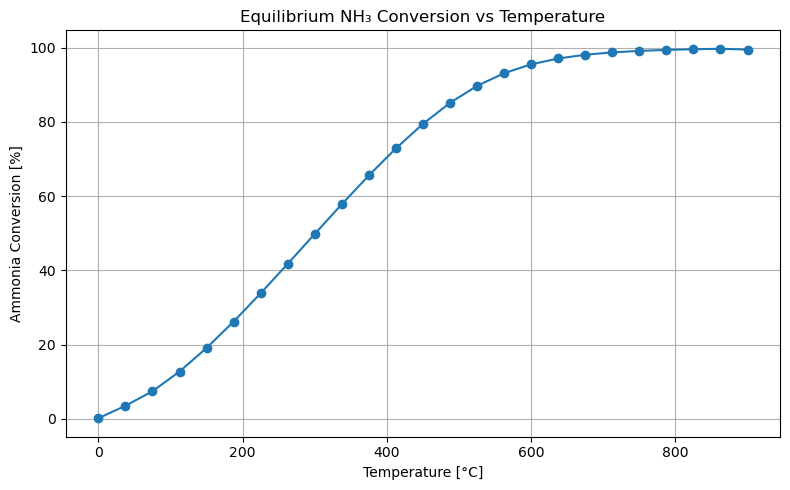

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import value, SolverFactory

# Temperature range in Celsius, then convert to Kelvin
temps_C = np.linspace(0, 900, 25)
temps_K = temps_C + 273.15
conversions = []

for T_K in temps_K:
    try:
        cm, _, _, _ = simulate_cracker()

        t0 = cm.fs.time.first()
        cm.fs.cracker.inlet.temperature[t0].fix(T_K)

        solver = SolverFactory("ipopt")
        solver.solve(cm, tee=False)

        n_in = value(cm.fs.cracker.control_volume.properties_in[t0].flow_mol_comp["NH3"])
        n_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol_comp["NH3"])
        conversion = (n_in - n_out) / n_in

        conversions.append(conversion)
        print(f"T = {T_K:.1f} K ({T_K - 273.15:.1f} °C) -> Conversion = {conversion:.3f}")

    except Exception as e:
        print(f"Solver failed at T = {T_K:.1f} K: {e}")
        conversions.append(np.nan)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(temps_C, np.array(conversions) * 100, marker='o')
plt.xlabel("Temperature [°C]")
plt.ylabel("Ammonia Conversion [%]")
plt.title("Equilibrium NH₃ Conversion vs Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:

def simulate_cracker(eos=EosType.PR):
    cm = pyo.ConcreteModel()
    cm.fs = FlowsheetBlock(dynamic=False)

    # Components and properties of feed stream
    components = {"NH3":1 - 2 * 1e-19, "H2":1e-19, "N2":1e-19}

    cm.fs.prop = GenericParameterBlock(
        **get_prop(components, phases={"Vap"}, eos=eos),
        doc="NH3 cracking property package"
    )
    cm.fs.rxn = GenericReactionParameterBlock(
        **get_rxn(cm.fs.prop, {"nh3_crk_eq"})
    )

    # Cracker as EquilibriumReactor
    from idaes.models.unit_models import EquilibriumReactor

    cm.fs.cracker = EquilibriumReactor(
        property_package=cm.fs.prop,
        reaction_package=cm.fs.rxn,
        has_heat_transfer=True,
        has_pressure_change=False,
        has_heat_of_reaction=False,
        has_equilibrium_reactions =True,
        has_rate_reactions = False, 
    )
     
    
    # Fix feed conditions
    t0 = cm.fs.time.first()
    time = cm.fs.time
    cm.fs.cracker.inlet.flow_mol[t0].fix(0.08)            # 2/3 * 0.075397 mol/s
    cm.fs.cracker.inlet.temperature[t0].fix(573.15)      #942.05 K = inlet of the SOFC model
    cm.fs.cracker.inlet.pressure[t0].fix(101325)         # Pa
    cm.fs.cracker.inlet.mole_frac_comp[t0, "NH3"].fix(components['NH3'])
    cm.fs.cracker.inlet.mole_frac_comp[t0, "H2"].fix(components['H2'])
    cm.fs.cracker.inlet.mole_frac_comp[t0, "N2"].fix(components['N2'])
    

    
    @cm.fs.cracker.Constraint(time)
    def heat_rule(b, t):
         return b.control_volume.heat[t] ==  1051

    iscale.calculate_scaling_factors(cm)

    # Inizializzazione
    cm.fs.cracker.initialize()

    # Simulazione
    solver = pyo.SolverFactory("ipopt")
    results = solver.solve(cm, tee=False)

    # Report
    print("\n--- NH3 CRACKER RESULTS ---\n")
    report_statistics(cm)
    flow_in = value(cm.fs.cracker.control_volume.properties_in[t0].flow_mol)
    flow_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol)
    T_out = value(cm.fs.cracker.control_volume.properties_out[t0].temperature)
    T_in = value(cm.fs.cracker.control_volume.properties_in[t0].temperature)
    x_out = {j: value(cm.fs.cracker.control_volume.properties_out[t0].mole_frac_comp[j]) for j in components}
    #Q_rxn = value(cm.fs.cracker.control_volume.heat_of_reaction[t0])
    Q_rxn_heat = value(cm.fs.cracker.control_volume.heat[t0])
    H2_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol_comp["H2"])
    NH3_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol_comp["NH3"])
    N2_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol_comp["N2"])
    n_in = value(cm.fs.cracker.control_volume.properties_in[t0].flow_mol_comp["NH3"])
    n_out = value(cm.fs.cracker.control_volume.properties_out[t0].flow_mol_comp["NH3"])
    Ammonia_consumption = (n_in - n_out) / n_in * 100
    extent = value(cm.fs.cracker.control_volume.equilibrium_reaction_extent[t0, "nh3_crk_eq"])


    print(f"Degrees of Freedom: {degrees_of_freedom(cm)}")
    print(f"Feed Flow [mol/s]: {flow_in:.4f}")
    print(f"Outlet Flow [mol/s]: {flow_out:.4f}")
    print(f"Outlet Temperature [K]: {T_out:.2f}")
    print(f"Inlet Temperature [K]: {T_in:.2f}")
    print(f"Outlet Composition: {x_out}")
    #print(f"Heat of Reaction [W]: {Q_rxn:.2f}")
    print(f"Heat [W]: {Q_rxn_heat:.2f}")
    print(f"H2 Molar FLow: {H2_out:.5f}mol/s")
    print(f"NH3 Molar FLow: {NH3_out:.5f}mol/s")
    print(f"N2 Molar FLow: {N2_out:.5f}mol/s")
    print(f"Ammonia Consumption: {Ammonia_consumption:.2f}%")
    print(f"Equilibrium reaction extent: {extent:.5f} ")

    # Visualizzazione della rete del modello
    visualize(cm.fs, "NH3 Cracker")

    return cm, flow_out, T_out, x_out #Q_rxn
cm, flow_out, T_out, x_out = simulate_cracker()
#print(flow_out, T_out, x_out, Q_rxn)

2025-08-04 09:49:46 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.properties_in[0.0].enth_mol_phase[Vap], for _enthalpy_flow_term
2025-08-04 09:49:46 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.properties_out[0.0].enth_mol_phase[Vap], for _enthalpy_flow_term
2025-08-04 09:49:46 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.equilibrium_reaction_extent[0.0,nh3_crk_eq]
2025-08-04 09:49:46 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.equilibrium_reaction_extent[0.0,nh3_crk_eq]
2025-08-04 09:49:46 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.equilibrium_reaction_extent[0.0,nh3_crk_eq]
2025-08-04 09:49:46 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.cracker.control_volume.heat
2025-08-04 09:49:46 [INFO] idaes.init.fs.cracker.control_volume.properties_in: Startin

In [8]:
 # Visualizzazione della rete del modello
visualize(cm.fs.cracker, "NH3 Cracker")

2025-08-04 09:45:13 [INFO] idaes.idaes_ui.fv.fsvis: Using HTTP server on localhost, port 50952
2025-08-04 09:45:13 [INFO] idaes.idaes_ui.fv.fsvis: Loading saved flowsheet from 'NH3 Cracker.json'
2025-08-04 09:45:13 [INFO] idaes.idaes_ui.fv.fsvis: Saving flowsheet to default file 'NH3 Cracker.json' in current directory (c:\Users\Sara\Desktop\IDAES\22072025)
2025-08-04 09:45:13 [WARNING] idaes.idaes_ui.fv.fsvis: Flowsheet name changed: old='NH3 Cracker' new='NH3-Cracker'
Flowsheet name changed to 'NH3-Cracker'
2025-08-04 09:45:13 [INFO] idaes.idaes_ui.fv.fsvis: Flowsheet visualization at: http://localhost:50952/app?id=NH3-Cracker


VisualizeResult(store=<idaes_ui.fv.persist.FileDataStore object at 0x000001C65791A170>, port=50952, server=<idaes_ui.fv.model_server.FlowsheetServer object at 0x000001C65791A440>)